In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes, load_digits

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
def plot_scatter(x, y, auto_scaled = True, title = None, clusters = None):
    plt.figure(figsize = (4, 4))
    plt.scatter(x, y, c = clusters, cmap = 'bwr')

    if not auto_scaled:
        plt.axis('square')

    plt.grid(True)
    plt.title(title)

    plt.show()


def return_X_y(data, target_column):
    return data.drop(target_column, axis = 1), data[target_column]

In [4]:
wine_sklearn = load_wine(as_frame = True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [5]:
# 1 point
def scale(X):
    return (X - np.mean(X)) / np.std(X)

In [6]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))

C:\Users\aliaksei\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


### Pipeline Version (2 points)

In [7]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin


class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, copy = True, with_mean = True, with_std = True):
        self.copy = copy
        self.with_mean = with_mean
        self.with_std = with_std
        self.mean = None
        self.std = None

    def fit(self, X, y = None):
        self.mean = np.mean(X) if self.with_mean else None
        self.std = np.std(X) if self.with_std else None

        return self

    def transform(self, X, y = None, copy = None):
        copy = copy if copy else self.copy
        x_copy = X.copy() if copy else X

        if self.with_mean:
            x_copy = x_copy - self.mean

        if self.with_std:
            x_copy = x_copy / self.std

        return x_copy

In [8]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))

C:\Users\aliaksei\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [9]:
feature_0 = np.random.randn(1000) * 10
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data

array([[  8.18124259,  -0.36939398],
       [-23.0466935 ,   0.19509347],
       [  5.59953813,   0.4031301 ],
       ...,
       [ -7.53376538,   4.31406304],
       [ 11.40611437,   4.11807357],
       [-10.01163477,   5.3984662 ]])

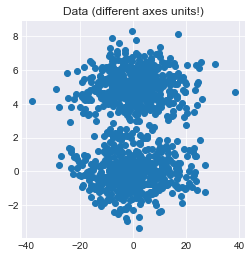

In [10]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled = True, title = 'Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

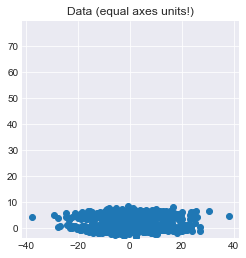

In [11]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled = False, title = 'Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (0.5 point)

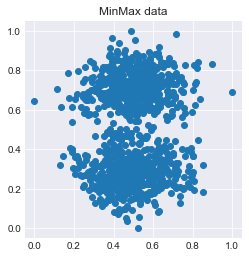

In [12]:
min_max_data = MinMaxScaler().fit_transform(data)
plot_scatter(min_max_data[:, 0], min_max_data[:, 1], auto_scaled = False, title = 'MinMax data')

### StandardScaler (0.5 point)

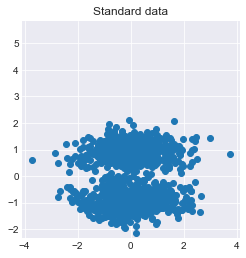

In [13]:
stand_data = StandardScaler().fit_transform(data)
plot_scatter(stand_data[:, 0], stand_data[:, 1], auto_scaled = False, title = 'Standard data')

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2)

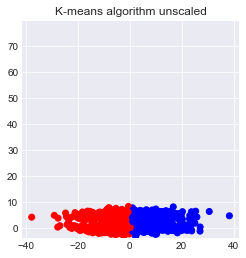

In [15]:
kmeans.fit(data)
plot_scatter(data[:, 0], data[:, 1], auto_scaled = False, title = 'K-means algorithm unscaled',
             clusters = kmeans.labels_)

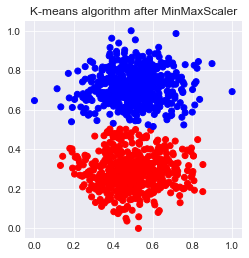

In [16]:
kmeans.fit(min_max_data)
plot_scatter(min_max_data[:, 0], min_max_data[:, 1], auto_scaled = False,
             title = 'K-means algorithm after MinMaxScaler', clusters = kmeans.labels_)

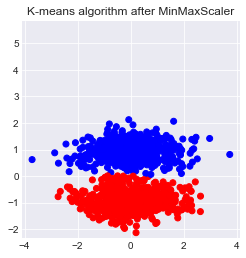

In [17]:
kmeans.fit(stand_data)
plot_scatter(stand_data[:, 0], stand_data[:, 1], auto_scaled = False, title = 'K-means algorithm after MinMaxScaler',
             clusters = kmeans.labels_)

## Exercise  3 - Preprocessing Pipeline (2 points)

In [18]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels,
                                                                            test_size = 0.3, random_state = 42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

In [19]:
wine_train

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
138,13.49,3.59,2.19,19.5,88.0,1.62,0.48,0.58,0.88,5.70,0.81,1.82,580.0
104,12.51,1.73,1.98,20.5,85.0,2.20,1.92,0.32,1.48,2.94,1.04,3.57,672.0
78,12.33,0.99,1.95,14.8,136.0,1.90,1.85,0.35,2.76,3.40,1.06,2.31,750.0
36,13.28,1.64,2.84,15.5,110.0,2.60,2.68,0.34,1.36,4.60,1.09,2.78,880.0
93,12.29,2.83,2.22,18.0,88.0,2.45,2.25,0.25,1.99,2.15,1.15,3.30,290.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,13.86,1.51,2.67,25.0,86.0,2.95,2.86,0.21,1.87,3.38,1.36,3.16,410.0
106,12.25,1.73,2.12,19.0,80.0,1.65,2.03,0.37,1.63,3.40,1.00,3.17,510.0
14,14.38,1.87,2.38,12.0,102.0,3.30,3.64,0.29,2.96,7.50,1.20,3.00,1547.0
92,12.69,1.53,2.26,20.7,80.0,1.38,1.46,0.58,1.62,3.05,0.96,2.06,495.0


In [20]:
def model_selector(models, x_train, y_train, x_test, y_test):
    stats = pd.DataFrame({
        'model': {},
        'accuracy_train': {},
        'accuracy_test': {},
        'cross_val_mean': {}
    })

    for model in models:
        model.fit(x_train, y_train)
        stats.loc[len(stats.index)] = [
            model,
            accuracy_score(y_train, model.predict(x_train)),
            accuracy_score(y_test, model.predict(x_test)),
            cross_val_score(model, pd.concat([x_train, x_test]), pd.concat([y_train, y_test]), cv = 10).mean()
        ]

    return stats

### Raw data

In [21]:
model = LogisticRegression(solver = 'liblinear', penalty = 'l1')
raw_models = model_selector([model], wine_train, wine_labels_train, wine_val, wine_labels_val)
raw_models.drop('model', axis = 1)

,accuracy_train,accuracy_test,cross_val_mean
0,0.967742,0.981481,0.944444


### Scaled data

In [22]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver = 'liblinear', penalty = 'l1')),
])
scaled_models = model_selector([model], wine_train, wine_labels_train, wine_val, wine_labels_val)
scaled_models.drop('model', axis = 1)

C:\Users\aliaksei\AppData\Roaming\Python\Python310\site-packages\pandas\core\dtypes\cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


,accuracy_train,accuracy_test,cross_val_mean
0,1.0,0.981481,0.988889


### Feature Selection

Let analyze `VarianceThreshold` with different treshold

In [23]:
def scaled_model(selector):
    return Pipeline([
        ('selector', selector),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(solver = 'liblinear', penalty = 'l1')),
    ])

#### VarianceThreshold

Let analyze different variance treshhold

In [24]:
def treshold_stats(range, x_train, x_test, y_train, y_test):
    var_models = pd.DataFrame(index = range)
    var_models['model'] = var_models.index.map(lambda x: scaled_model(VarianceThreshold(x)))
    var_stats = model_selector(var_models['model'], x_train, x_test, y_train, y_test)
    var_stats.drop('model', axis = 1, inplace = True)
    var_stats.index = var_models.index
    return var_models.join(var_stats)

C:\Users\aliaksei\AppData\Roaming\Python\Python310\site-packages\pandas\core\dtypes\cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


,accuracy_train,accuracy_test,cross_val_mean
0.0,1.000000,0.981481,0.988889
0.1,0.967742,1.000000,0.972222
0.2,0.967742,1.000000,0.972222
0.3,0.967742,1.000000,0.972222
0.4,0.967742,1.000000,0.972222
...,...,...,...
9.5,0.693548,0.777778,0.697059
9.6,0.693548,0.777778,0.697059
9.7,0.693548,0.777778,0.697059
9.8,0.693548,0.777778,0.697059


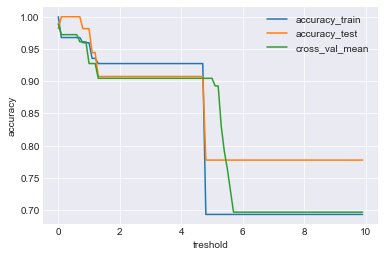

In [25]:
var_models = treshold_stats(np.round(np.arange(0.0, 10, 0.1), 1), wine_train, wine_labels_train, wine_val,
                            wine_labels_val)
var_models.plot(xlabel = 'treshold', ylabel = 'accuracy')
var_models.drop('model', axis = 1)

C:\Users\aliaksei\AppData\Roaming\Python\Python310\site-packages\pandas\core\dtypes\cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


,accuracy_train,accuracy_test,cross_val_mean
0.00,1.000000,0.981481,0.988889
0.05,1.000000,0.981481,0.988889
0.10,0.967742,1.000000,0.972222
0.15,0.967742,1.000000,0.972222
0.20,0.967742,1.000000,0.972222
0.25,0.967742,1.000000,0.972222
0.30,0.967742,1.000000,0.972222
0.35,0.967742,1.000000,0.972222
0.40,0.967742,1.000000,0.972222
0.45,0.967742,1.000000,0.972222


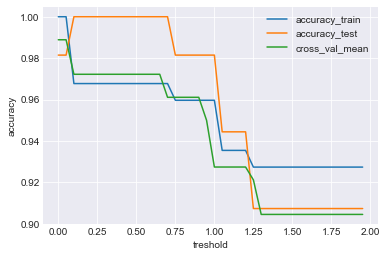

In [26]:
var_models = treshold_stats(np.round(np.arange(0.0, 2, 0.05), 2), wine_train, wine_labels_train, wine_val,
                            wine_labels_val)
var_models.plot(xlabel = 'treshold', ylabel = 'accuracy')
var_models.drop('model', axis = 1)

C:\Users\aliaksei\AppData\Roaming\Python\Python310\site-packages\pandas\core\dtypes\cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


,accuracy_train,accuracy_test,cross_val_mean
0.00,1.000000,0.981481,0.988889
0.01,1.000000,0.981481,0.988889
0.02,1.000000,0.981481,0.988889
0.03,1.000000,0.981481,0.988889
0.04,1.000000,0.981481,0.988889
0.05,1.000000,0.981481,0.988889
0.06,1.000000,1.000000,0.977778
0.07,1.000000,1.000000,0.977778
0.08,0.967742,1.000000,0.972222
0.09,0.967742,1.000000,0.972222


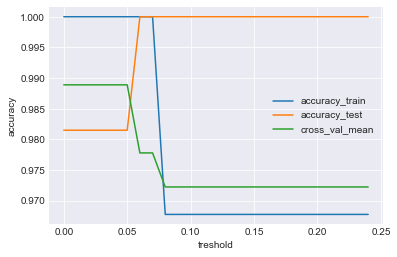

In [27]:
var_models = treshold_stats(np.round(np.arange(0.0, 0.25, 0.01), 2), wine_train, wine_labels_train, wine_val,
                            wine_labels_val)
var_models.plot(xlabel = 'treshold', ylabel = 'accuracy')
var_models.drop('model', axis = 1)

C:\Users\aliaksei\AppData\Roaming\Python\Python310\site-packages\pandas\core\dtypes\cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


,accuracy_train,accuracy_test,cross_val_mean
0.00,1.000000,0.981481,0.988889
0.01,1.000000,0.981481,0.988889
0.02,1.000000,0.981481,0.988889
0.03,1.000000,0.981481,0.988889
0.04,1.000000,0.981481,0.988889
0.05,1.000000,0.981481,0.988889
0.06,1.000000,1.000000,0.977778
0.07,1.000000,1.000000,0.977778
0.08,0.967742,1.000000,0.972222
0.09,0.967742,1.000000,0.972222


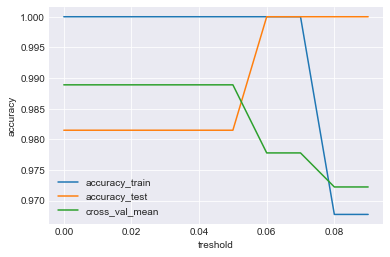

In [28]:
var_models = treshold_stats(np.round(np.arange(0.0, 0.1, 0.01), 2), wine_train, wine_labels_train, wine_val,
                            wine_labels_val)
var_models.plot(xlabel = 'treshold', ylabel = 'accuracy')
var_models.drop('model', axis = 1)

We see that `treshold` = 0.06 or 0.07 is optimal

Let look at skipped columns:

In [29]:
pd.Series(wine_train.columns)[~var_models.loc[0.06]['model']['selector'].get_support()]

7     nonflavanoid_phenols
10                     hue
dtype: object

In [30]:
pd.Series(wine_train.columns)[~var_models.loc[0.07]['model']['selector'].get_support()]

7     nonflavanoid_phenols
10                     hue
dtype: object

We see, that in both case we have the same skipped columns: `nonflavanoid_phenols`, `hue`

#### SelectKBest

In [31]:
np.arange(len(wine_train.columns) + 1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [32]:
from sklearn.feature_selection import SelectKBest

best_k_models = pd.DataFrame(index = np.arange(1, len(wine_train.columns) + 1))
best_k_models['model'] = best_k_models.index.map(lambda x: scaled_model(SelectKBest(k = x)))
best_k_stats = model_selector(best_k_models['model'], wine_train, wine_labels_train, wine_val, wine_labels_val)
best_k_stats.drop('model', axis = 1, inplace = True)
best_k_stats.index = best_k_models.index
best_k_models = best_k_models.join(best_k_stats)

C:\Users\aliaksei\AppData\Roaming\Python\Python310\site-packages\pandas\core\dtypes\cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


,model,accuracy_train,accuracy_test,cross_val_mean
1,"(SelectKBest(k=1), StandardScaler(), LogisticR...",0.782258,0.833333,0.797712
2,"(SelectKBest(k=2), StandardScaler(), LogisticR...",0.814516,0.814815,0.899346
3,"(SelectKBest(k=3), StandardScaler(), LogisticR...",0.911290,0.962963,0.927124
4,"(SelectKBest(k=4), StandardScaler(), LogisticR...",0.959677,1.000000,0.949673
5,"(SelectKBest(k=5), StandardScaler(), LogisticR...",0.975806,1.000000,0.972222
6,"(SelectKBest(k=6), StandardScaler(), LogisticR...",0.975806,1.000000,0.983333
7,"(SelectKBest(k=7), StandardScaler(), LogisticR...",0.983871,1.000000,0.977778
8,"(SelectKBest(k=8), StandardScaler(), LogisticR...",0.991935,1.000000,0.966667
9,"(SelectKBest(k=9), StandardScaler(), LogisticR...",0.983871,1.000000,0.977778
10,"(SelectKBest(), StandardScaler(), LogisticRegr...",0.983871,1.000000,0.983333


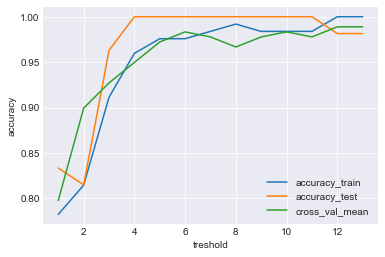

In [33]:
best_k_models.plot(xlabel = 'treshold', ylabel = 'accuracy')
best_k_models

The best result is happened when k=10

Let look at skipped columns

In [34]:
pd.Series(wine_train.columns)[~best_k_models.loc[10]['model']['selector'].get_support()]

2                     ash
4               magnesium
7    nonflavanoid_phenols
dtype: object

So, let look at different models

In [35]:
raw_models.loc[0]

model             LogisticRegression(penalty='l1', solver='libli...
accuracy_train                                             0.967742
accuracy_test                                              0.981481
cross_val_mean                                             0.944444
Name: 0, dtype: object

### Conclusion

In [36]:
models = pd.DataFrame(columns = ['model', 'accuracy_train', 'accuracy_test', 'cross_val_mean'])
models.loc[0] = raw_models.loc[0]
models.loc[1] = scaled_models.loc[0]
models.loc[2] = var_models.loc[0.06]
models.loc[3] = best_k_models.loc[10]
models

,model,accuracy_train,accuracy_test,cross_val_mean
0,"LogisticRegression(penalty='l1', solver='libli...",0.967742,0.981481,0.944444
1,"(StandardScaler(), LogisticRegression(penalty=...",1.0,0.981481,0.988889
2,"(VarianceThreshold(threshold=0.06), StandardSc...",1.0,1.0,0.977778
3,"(SelectKBest(), StandardScaler(), LogisticRegr...",0.983871,1.0,0.983333


We see, that in our case we cannot achieve much better resultwith feature selection(have better accuracy - worse cross_val)

## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

In [37]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Find a covariance matrix of standartized data and assing it to S.

In [38]:
S = pd.DataFrame(StandardScaler().fit_transform(wine_data), columns = wine_data.columns).cov()
S

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
alcohol,1.005650,0.094930,0.212740,-0.311988,0.272328,0.290734,0.238153,-0.156810,0.137470,0.549451,-0.072153,0.072752,0.647357
malic_acid,0.094930,1.005650,0.164972,0.290130,-0.054883,-0.337061,-0.413329,0.294632,-0.221993,0.250392,-0.564467,-0.370794,-0.193095
ash,0.212740,0.164972,1.005650,0.445872,0.288206,0.129708,0.115727,0.187283,0.009706,0.260350,-0.075089,0.003933,0.224890
alcalinity_of_ash,-0.311988,0.290130,0.445872,1.005650,-0.083804,-0.322928,-0.353355,0.363966,-0.198442,0.018838,-0.275503,-0.278332,-0.443086
magnesium,0.272328,-0.054883,0.288206,-0.083804,1.005650,0.215613,0.196890,-0.257742,0.237776,0.201080,0.055711,0.066377,0.395573
total_phenols,0.290734,-0.337061,0.129708,-0.322928,0.215613,1.005650,0.869448,-0.452477,0.615873,-0.055448,0.436132,0.703904,0.500929
flavanoids,0.238153,-0.413329,0.115727,-0.353355,0.196890,0.869448,1.005650,-0.540939,0.656379,-0.173353,0.546549,0.791641,0.496985
nonflavanoid_phenols,-0.156810,0.294632,0.187283,0.363966,-0.257742,-0.452477,-0.540939,1.005650,-0.367912,0.139843,-0.264123,-0.506113,-0.313144
proanthocyanins,0.137470,-0.221993,0.009706,-0.198442,0.237776,0.615873,0.656379,-0.367912,1.005650,-0.025393,0.297214,0.522000,0.332283
color_intensity,0.549451,0.250392,0.260350,0.018838,0.201080,-0.055448,-0.173353,0.139843,-0.025393,1.005650,-0.524761,-0.431238,0.317886


If your code is correct, the following assert should be Ok.

In [39]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)

In [40]:
from scipy.optimize import minimize


def objective(x):
    return x - S


# your code: write objective of the problem (don't forget that scipy does min while we need max)

def norm_constraint(x):
    return x - np.mean(x)

# your code: constaraint norm of x to be 1, function should return 0 if constraint holds

##con1 = {'type': 'eq', 'fun': norm_constraint}

##x0 =  [0,0,0,1,1,1,0,0,0,1,1,1,1]

##sol = minimize(objective,
##               x0,
##               constraints = [con1]
##               )
##x0 = sol.x

Hurray! We have first vector! Let's do another one.

In [41]:
##def orthogonality_constraint(x):


# your code: x should be orthogonal to x0, function should return 0 if constraint holds

##con2 = {'type': 'eq', 'fun': orthogonality_constraint}

##x1 =  # your code: initial vector to start optimization

##sol = minimize(objective,
##               x1,
##               constraints =  #your code
##               )

##x1 = sol.x

If your solution is correct, the following asserts should be Ok.

In [42]:
##assert np.allclose(x0 @ S @ x0, 4.732436977583595)
##assert np.allclose(x1 @ S @ x1, 2.5110809296451233)

### Visualization (2 points)

Visualize the points after applying custom dimension reduction with 2 components.

## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [43]:
X, y = load_digits(n_class = 3, return_X_y = True, as_frame = True)
X = (X > 10).astype(int)

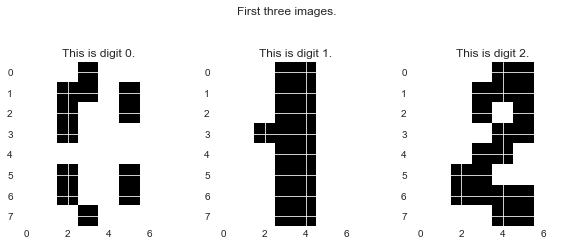

In [44]:
f, ax = plt.subplots(1, 3, figsize = (10, 4))
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8, 8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [46]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [47]:
clf = RandomForestClassifier(max_depth = 13)
clf.fit(X_train, y_train)

acc = accuracy_score(y_val, clf.predict(X_val))
print(acc)

0.9938271604938271


In [48]:
assert acc > 0.98

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [49]:
#!pip install boruta

In [50]:
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth = 13),
                         n_estimators = 'auto',
                         verbose = 0,
                         max_iter = 100,
                         random_state = 42)

feat_selector.fit_transform(X_train.values, y_train.ravel())

array([[0, 1, 1, ..., 1, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 1, 1],
       ...,
       [0, 1, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 1, 1, ..., 1, 1, 1]])

Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

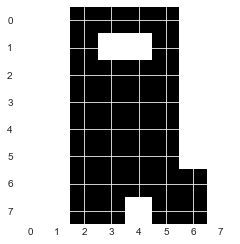

In [51]:
mask = np.array(feat_selector.support_).reshape(8, 8)
plt.gca().set_xticks(np.arange(8))
plt.imshow(mask);

At the end let us redo  classification but only with selected features

In [52]:
columns_to_drop = ['pixel_0_0', 'pixel_0_1', 'pixel_0_6', 'pixel_0_7',
                   'pixel_1_0', 'pixel_1_1', 'pixel_1_3', 'pixel_1_4', 'pixel_1_6', 'pixel_1_7',
                   'pixel_2_0', 'pixel_2_1', 'pixel_2_6', 'pixel_2_7',
                   'pixel_3_0', 'pixel_3_1', 'pixel_3_6', 'pixel_3_7',
                   'pixel_4_0', 'pixel_4_1', 'pixel_4_6', 'pixel_4_7',
                   'pixel_5_0', 'pixel_5_1', 'pixel_5_6', 'pixel_5_7',
                   'pixel_6_0', 'pixel_6_1', 'pixel_6_7',
                   'pixel_7_0', 'pixel_7_1', 'pixel_7_2', 'pixel_7_3', 'pixel_7_4', 'pixel_7_5', 'pixel_7_6',
                   'pixel_7_7']

X_train.drop(columns_to_drop, axis = 1, inplace = True)
X_val.drop(columns_to_drop, axis = 1, inplace = True)

In [53]:
clf = RandomForestClassifier(max_depth = 13)

clf.fit(X_train, y_train)
acc = accuracy_score(y_val, clf.predict(X_val))
acc

1.0

In [54]:
assert acc > 0.99

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market